In [109]:
#show line numbers 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
!python3 -m pip install --upgrade pip

In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
!pip3 install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 59.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
!pip3 install -U scikit-learn scipy matplotlib

In [3]:
!brew install unrar
!brew install rar

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
ancient                    grayskull                  podsync
aptos                      juicefs                    prs
aws-sam-cli                kwctl                      qdmr
bzip3                      kwok                       quartz-wm
cargo-make                 libaribcaption             scriptisto
cargo-release              liblerc                    simdutf
cascadia                   libsais                    tetra
cdebug                     m1ddc                      twm
check-jsonschema           mdless                     xcdiff
clang-build-analyzer       ocm                        xinit
copa                       okta-awscli                xmodmap
crfsuite                   opencl-clhpp-headers       xorg-server
dstack                     openvino                   xrdb
ecoji                      pari-nflistdata            zsh-autopair
flag

In [8]:
!sudo apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 113 kB of archives.
After this operation, 406 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 unrar amd64 1:5.6.6-2build1 [113 kB]
Fetched 113 kB in 0s (287 kB/s) 
Selecting previously unselected package unrar.
(Reading database ... 272556 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a5.6.6-2build1_amd64.deb ...
Unpacking unrar (1:5.6.6-2build1) ...
Setting up unrar (1:5.6.6-2build1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode
Processing triggers for man-db (2.9.1-1) ...


In [1]:
!unzip EFPDS-Frames.zip

Archive:  EFPDS-Frames.zip
  inflating: __MACOSX/._EFPDS-Frames  
  inflating: __MACOSX/EFPDS-Frames/._No Fall  
replace EFPDS-Frames/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
#get UCF101 data

!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar

--2023-02-07 02:36:13--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/rar]
Saving to: ‘UCF101.rar’

UCF101.rar          100%[===================>]   6.46G  36.7MB/s    in 3m 1s   

2023-02-07 02:39:14 (36.6 MB/s) - ‘UCF101.rar’ saved [6932971618/6932971618]

/usr/bin/sh: 1: unrar: not found


In [11]:
!unrar x UCF101.rar -y


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from UCF101.rar

Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c06.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c01.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c02.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c03.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c04.avi          0  OK 
Extracting  UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g03_c01.avi          0  OK 
Extracting  UCF-

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import cv2

import time
import os
import shutil
import copy
import math
import random
import numpy as np
import datetime as dt

cudnn.benchmark = True
plt.ion()   # interactive mode

/Users/davidjr/Desktop/CompSci stuff/resnet50stuff/actionRecognitionEnv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check pytorch version
print(torch.__version__)

1.13.1


In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)

In [4]:
# BELOW IS FOR USE WITH UCF-101

In [5]:
data_dir = 'UCF-101'
frame_dir = 'UCF-101-Frames'

#make folder for frame_dir if it doesn't exist
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

# Get Names of all classes in UCF50
all_classes_list = os.listdir('UCF-101')
classes_list = ["PullUps", "JumpingJack", "HighJump"]

In [6]:
#Frame Extraction  -  January 11/2023! Less goooo

for class_name in classes_list:
    videos_list = os.listdir(os.path.join(data_dir, class_name))
    for video_name in videos_list:
        # Open the video
        video_file_path = os.path.join(data_dir, class_name, video_name)
        cap = cv2.VideoCapture(video_file_path)

        # Extract the frames for each class
        frame_count = 0
        while True:
            # Read the next frame
            ret, frame = cap.read()

            if not ret:
                break

            # See if folder for class exists, if not make one
            class_folder_path = os.path.join(frame_dir, class_name)
            if not os.path.exists(class_folder_path):
                os.makedirs(class_folder_path)
            
            # Save the frame to disk
            cv2.imwrite(os.path.join(frame_dir, class_name, f'{video_name}_frame_{frame_count}.jpg'), frame)
                        
            frame_count += 1

        # Release the video capture
        cap.release()

KeyboardInterrupt: 

In [50]:
# BELOW IS FOR USE WITH EFPDS DATASET

In [6]:
def get_folders(path):
    return [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]


In [7]:
data_dir = 'EFPDS'
frame_dir = 'EFPDS-Frames'

#make folder for frame_dir if it doesn't exist
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

classes_list = ["Fall", "No Fall"]
all_classes_list = get_folders(frame_dir)
print(all_classes_list)

for class_item in classes_list:
    class_dir = os.path.join(frame_dir, class_item)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

['No Fall', 'Fall']


In [9]:
data_sub_dir_list = ['train 3', 'valid', 'test']

# if a video contains even one fallen person, it is classified as 'fall'

for sub_dir in data_sub_dir_list:
    data_sub_dir = os.path.join(data_dir, sub_dir)
    for split in get_folders(data_sub_dir):
        data_split_dir = os.path.join(data_sub_dir, split)
        for file in os.listdir(data_split_dir):
            if file.endswith("png"):
                file_dir = os.path.join(data_split_dir, file)
                file_info_dir = os.path.splitext(file_dir)[0] + ".txt"
                did_file_moved = False
                with open(file_info_dir, 'r') as file: #with ensures that the file is closed after reading
                    current_line = file.readline()
                    while current_line:
                        file_value = current_line.split(" ")[0]
                        if int(file_value) == 1:
                            shutil.move(file_dir, os.path.join(frame_dir, classes_list[0]))
                            did_file_moved = True
                            break
                        else:
                            current_line = file.readline()
                if not did_file_moved:
                    shutil.move(file_dir, os.path.join(frame_dir, classes_list[1]))
                
        

In [10]:
#############################################
# CALCULATE MEAN AND STD FOR DATATRANSFORMS #
#############################################
# image_dataset = datasets.ImageFolder(frame_dir)

# # Initialize a placeholder tensor to store all images in the dataset
# # Get the shape of the first image 
# sample_transformed_image = transforms.ToTensor()(image_dataset[0][0])
# image_shape = sample_transformed_image.shape

# # Initialize the placeholder tensor using the shape of the images
# all_images = torch.empty(size=(len(image_dataset), 3, *image_shape))

# # Iterate over the dataset and add each image to the placeholder tensor
# for i, (image, label) in enumerate(image_dataset):
#     all_images[i] = transforms.ToTensor()(image)

# # Calculate mean and std
# mean = torch.mean(all_images, dim=(0, 2, 3))
# std = torch.std(all_images, dim=(0, 2, 3))

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

height, width = 480, 640 #200 * 200 for UCF101 Dataset

data_transforms = transforms.Compose([
        transforms.CenterCrop((height, width)), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_dataset = datasets.ImageFolder(frame_dir, transform = data_transforms)#dataset of ALL theframes

train_dataset_size = int(len(image_dataset) * 0.8)
valid_dataset_size = len(image_dataset) - train_dataset_size
train_dataset, valid_dataset = data.random_split(image_dataset, [train_dataset_size, valid_dataset_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                             shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16,
                                             shuffle=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Update classes_list to match the order of the folders

classes_list = image_dataset.classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])


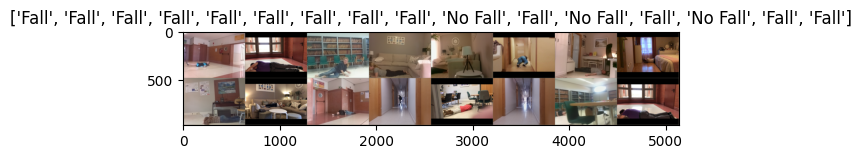

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
dataiter = iter(train_dataloader)
batch = next(dataiter)
inputs, classes = batch
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_list[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
                #set totrain dataloader and dataset size
                dataloader = train_dataloader
                dataset_size = train_dataset_size
                
            else:
                model.eval()   # Set model to evaluate mode
                
                #set to validation dataloader and dataset size
                dataloader = valid_dataloader
                dataset_size = valid_dataset_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_list[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = torch.load("actionRecognitionModel.pt", map_location=torch.device('cpu'))
model_ft.eval()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to amount of classes
model_ft.fc = nn.Linear(num_ftrs, len(classes_list))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


KeyboardInterrupt: 

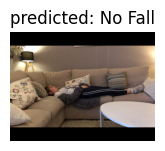

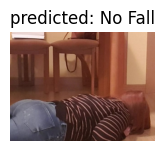

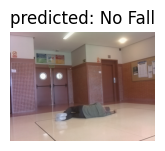

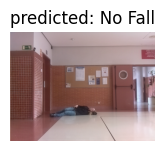

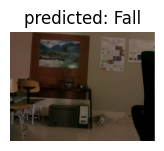

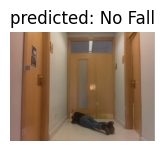

In [13]:
visualize_model(model_ft)

In [14]:
model_path = 'actionRecognitionModel.pt'

# save the model's state dictionary to the file
torch.save(model_ft.state_dict(), model_path)

In [24]:
# initialize video capture object for webcam
cap = cv2.VideoCapture(0)

# define the size of the resized frame
frame_size = (480,640)

# set model to evaluation mode
model_ft.eval()

while True:
    # capture frame-by-frame
    ret, frame = cap.read()

    if ret:
        # resize the frame to a fixed size
        frame = cv2.resize(frame, frame_size)

        # convert the frame to a PyTorch tensor
        tensor_frame = torch.from_numpy(np.expand_dims(frame.transpose((2, 0, 1)), axis=0)).float().div(255)

        # pass the tensor through the model to get the predictions
        with torch.no_grad():
            outputs = model_ft(tensor_frame)
            _, preds = torch.max(outputs, 1)
            print(f'predicted: {classes_list[preds[0]]}')

        # display classified frame
        cv2.imshow('Live Video Classification', frame)

    # exit loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release video capture object and close windows
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 